In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle

/Users/michal/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('../data/fer2013/fer2013.csv')
df.sample(5)

,emotion,pixels,Usage
14429,3,173 100 82 77 58 10 26 71 126 143 156 181 178 ...,Training
19056,3,201 203 206 208 210 214 216 217 238 244 200 22...,Training
30364,4,180 183 187 181 167 168 181 181 177 176 177 16...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
10226,0,254 217 94 51 45 42 42 39 55 78 116 139 136 13...,Training


In [3]:
def error_rate(pred, target):
    return np.mean(pred!=target)

In [4]:
def classification_rate(p, t):
    return np.mean(p == t)

In [5]:
def ohe(labels):
    ohe_lab = np.zeros((labels.shape[0], len(set(labels))))
    for i in range(len(labels)):
        ohe_lab[i, labels[i]] = 1
    return ohe_lab     

In [6]:
def rearrange(X):
    return (X.transpose(0, 2, 3, 1) / 255).astype(np.float32)

In [7]:
Y_all = df['emotion'].astype(int)
X_all = []
for i in df['pixels']:
    X_all.append([int(p) for p in i.split()]) #acts like getData()
X_all, Y_all = np.array(X_all), np.array(Y_all)
X_all = np.reshape(X_all, (X_all.shape[0], 1, 48, 48)) #acts like getImageData()

In [8]:
X = rearrange(X_all)
Y = ohe(Y_all)

In [9]:
print(X.shape)
print(type(X))
print(Y.shape)
print(type(Y))

(35887, 48, 48, 1)
<class 'numpy.ndarray'>
(35887, 7)
<class 'numpy.ndarray'>


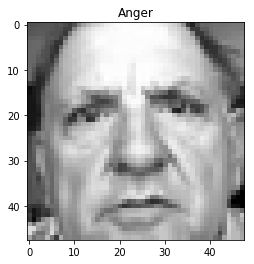

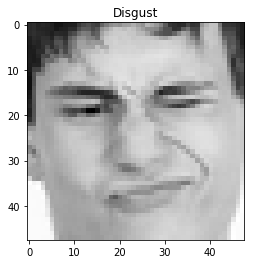

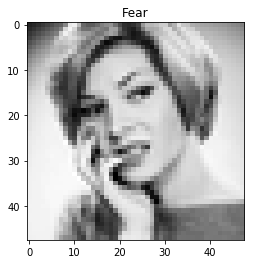

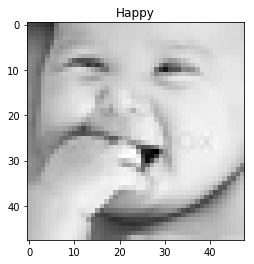

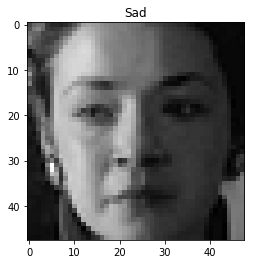

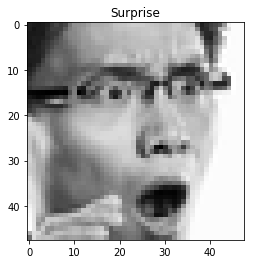

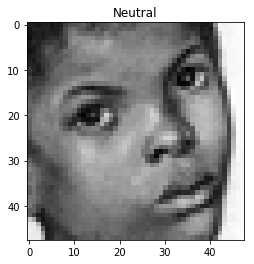

In [10]:
# show one of each emtion randomly
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

for i in range(7):
    x, y = X_all[Y_all==i], Y_all[Y_all==i]
    N = len(y)
    j = np.random.choice(N)
    plt.imshow(x[j].reshape(48,48), cmap='gray')
    plt.title(label_map[y[j]])
    plt.show()

In [11]:
def conv_pool(X, W, b):
    conv_out = tf.nn.conv2d(X, W, strides=[1,1,1,1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    conv_act = tf.nn.relu(conv_out)
    pool_out = tf.nn.max_pool(conv_act, [1,2,2,1], [1,2,2,1], padding='SAME')
    return pool_out

In [12]:
max_iter = 50
print_period = 20
lr = 1e-5
reg = 1e-2

In [13]:
X_train = X[:-1000]
Y_train = Y[:-1000]
X_test = X[-1000:]
Y_test = Y[-1000:]

In [14]:
N = X_train.shape[0]
batch_size = 256
num_batches = N//batch_size

In [15]:
# input filter size
# filter_size = (3, 3)
# filter_weighs -> (width, height, col_chan, feat_maps)
W1_cp_init = np.random.randn(3, 3, 1, 16)
b1_cp_init = np.zeros(16)
W2_cp_init = np.random.randn(3, 3, 16, 32)
b2_cp_init = np.zeros(32)
W3_cp_init = np.random.randn(3, 3, 32, 64)
b3_cp_init = np.zeros(64)

In [16]:
# image size = 6x6, num filters = 64
dense_input = 6*6*64 
dense_input

2304

In [17]:
# hidden layer1 nodes
M1 = 512
# hidden layer2 nodes
M2 = 256
# hidden layer3 nodes
M3 = 128
# output nodes
K = 7
# starting wieghts
W1_init = np.random.randn(dense_input, M1) / np.sqrt(dense_input+ M1)
b1_init = np.zeros(M1)
W2_init = np.random.randn(M1, M2) / np.sqrt(M1+M2)
b2_init = np.zeros(M2)
W3_init = np.random.randn(M2, M3) / np.sqrt(M2+M3)
b3_init = np.zeros(M3)
W4_init = np.random.randn(M3, K) / np.sqrt(M3+K)
b4_init = np.zeros(K)

In [18]:
# get TF variables for the inputs, X and targets T
ftX = tf.placeholder(tf.float32, shape=(None, 48, 48, 1), name='X')
ftT = tf.placeholder(tf.float32, shape=(None, K), name='T')

In [19]:
#get TF variables wieghts and biases - CONV
W1_cp = tf.Variable(W1_cp_init.astype(np.float32))
b1_cp = tf.Variable(b1_cp_init.astype(np.float32))
W2_cp = tf.Variable(W2_cp_init.astype(np.float32))
b2_cp = tf.Variable(b2_cp_init.astype(np.float32))
W3_cp = tf.Variable(W3_cp_init.astype(np.float32))
b3_cp = tf.Variable(b3_cp_init.astype(np.float32))

In [20]:
# get TF variables wieghts and biases _ DENSE
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))
W4 = tf.Variable(W4_init.astype(np.float32))
b4 = tf.Variable(b4_init.astype(np.float32))

In [21]:
Z1 = conv_pool(ftX, W1_cp, b1_cp)
Z2 = conv_pool(Z1, W2_cp, b2_cp)
Z3 = conv_pool(Z2, W3_cp, b3_cp)

Z3_shape = Z3.get_shape().as_list()
Z3_r = tf.reshape(Z3, [-1, np.prod(Z3_shape[1:])])

Z4 = tf.nn.relu(tf.matmul(Z3_r, W1)+b1)
Z5 = tf.nn.relu(tf.matmul(Z4, W2)+b2)
Z6 = tf.nn.relu(tf.matmul(Z5, W3)+b3)
Yish = tf.matmul(Z6, W4)+b4

In [22]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=ftT, logits=Yish)) #+ rcost

In [23]:
pred = tf.argmax(Yish, 1)

In [24]:
train_op = tf.train.RMSPropOptimizer(lr, decay=0.999, momentum=0.99).minimize(cost)

In [25]:
LL = []
error = []
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(max_iter):
        X_train, Y_train = shuffle(X_train, Y_train)
        for j in range(num_batches):
            X_batch = X_train[(j*batch_size):(j*batch_size+batch_size)]
            Y_batch = Y_train[(j*batch_size):(j*batch_size+batch_size)]
        
            sess.run(train_op, feed_dict = {ftX: X_batch, ftT: Y_batch})
            if j % print_period == 0:
                cost_val = sess.run(cost, feed_dict={ftX: X_test, ftT: Y_test})
                pred_val = sess.run(pred, feed_dict={ftX: X_test})
                err = error_rate(pred_val, Y_test.argmax(axis = 1))
                print(i,j,cost_val,err)
                LL.append(cost_val)
                error.append(err)

0 0 56.97063 0.972
0 20 19.258448 0.852
0 40 10.572841 0.815
0 60 8.546512 0.811
0 80 10.790043 0.788
0 100 13.37073 0.83
0 120 9.22308 0.82
1 0 6.436665 0.85
1 20 5.247936 0.797
1 40 5.9599533 0.777
1 60 5.1857195 0.795
1 80 2.9763021 0.837
1 100 3.002238 0.852
1 120 2.0900357 0.802
2 0 2.0900137 0.793
2 20 2.1071265 0.798
2 40 2.106962 0.751
2 60 1.9977404 0.801
2 80 1.9051356 0.763
2 100 1.8694513 0.804
2 120 1.8470168 0.768
3 0 1.8037072 0.757
3 20 1.7787558 0.726
3 40 1.8165532 0.744
3 60 1.7888901 0.728
3 80 1.7854365 0.729
3 100 1.7789729 0.733
3 120 1.7642944 0.736
4 0 1.77854 0.741
4 20 1.7483776 0.701
4 40 1.7494705 0.712
4 60 1.7630806 0.729
4 80 1.7488132 0.702
4 100 1.7473079 0.708
4 120 1.7603713 0.739
5 0 1.7399757 0.706
5 20 1.7478787 0.714
5 40 1.746778 0.726
5 60 1.7290379 0.68
5 80 1.7244678 0.705
5 100 1.7223608 0.704
5 120 1.7326031 0.676
6 0 1.718301 0.701
6 20 1.7328608 0.716
6 40 1.7120564 0.671
6 60 1.7193979 0.697
6 80 1.7130977 0.688
6 100 1.7162409 0.674
6 1

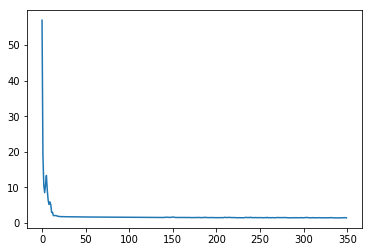

In [26]:
plt.plot(LL)
plt.show()

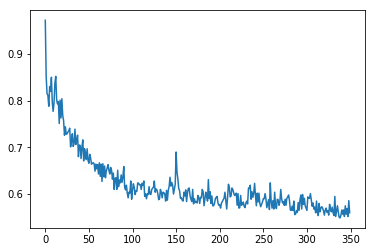

In [27]:
plt.plot(error)
plt.show()